In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from statsforecast import StatsForecast
from statsforecast.models import (
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    AutoARIMA,
    ARIMA,
    AutoETS
)


from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss

from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate



os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

In [13]:
df = pd.read_csv("ice-cream-train.csv")

print("Original data sample:")
print(df.head(20))
print("\nColumn names:", df.columns.tolist())
print("\nFirst few Month values:")
print(df["Month"].head(20))

Original data sample:
         Month  Icecream
0   01/01/1995    51.595
1   01/02/1995    56.086
2   01/03/1995    68.453
3   01/04/1995    65.722
4   01/05/1995    73.730
5   01/06/1995    77.994
6   01/07/1995    81.475
7   01/08/1995    74.981
8   01/09/1995    61.530
9   01/10/1995    60.022
10  01/11/1995    52.772
11  01/12/1995    50.850
12  01/01/1996    53.116
13  01/02/1996    57.463
14  01/03/1996    68.929
15  01/04/1996    69.673
16  01/05/1996    77.387
17  01/06/1996    86.814
18  01/07/1996    83.006
19  01/08/1996    79.260

Column names: ['Month', 'Icecream']

First few Month values:
0     01/01/1995
1     01/02/1995
2     01/03/1995
3     01/04/1995
4     01/05/1995
5     01/06/1995
6     01/07/1995
7     01/08/1995
8     01/09/1995
9     01/10/1995
10    01/11/1995
11    01/12/1995
12    01/01/1996
13    01/02/1996
14    01/03/1996
15    01/04/1996
16    01/05/1996
17    01/06/1996
18    01/07/1996
19    01/08/1996
Name: Month, dtype: str


In [14]:
df = df.rename(columns={
    "Month": "ds",
    "Icecream": "y"
})

df["ds"] = pd.to_datetime(df["ds"], format="%d/%m/%Y")
df = df.sort_values("ds").reset_index(drop=True)
df["unique_id"] = "ice_cream"
df = df[["unique_id", "ds", "y"]]

df.head()

,unique_id,ds,y
0,ice_cream,1995-01-01,51.595
1,ice_cream,1995-02-01,56.086
2,ice_cream,1995-03-01,68.453
3,ice_cream,1995-04-01,65.722
4,ice_cream,1995-05-01,73.730


In [15]:
len(df)

216

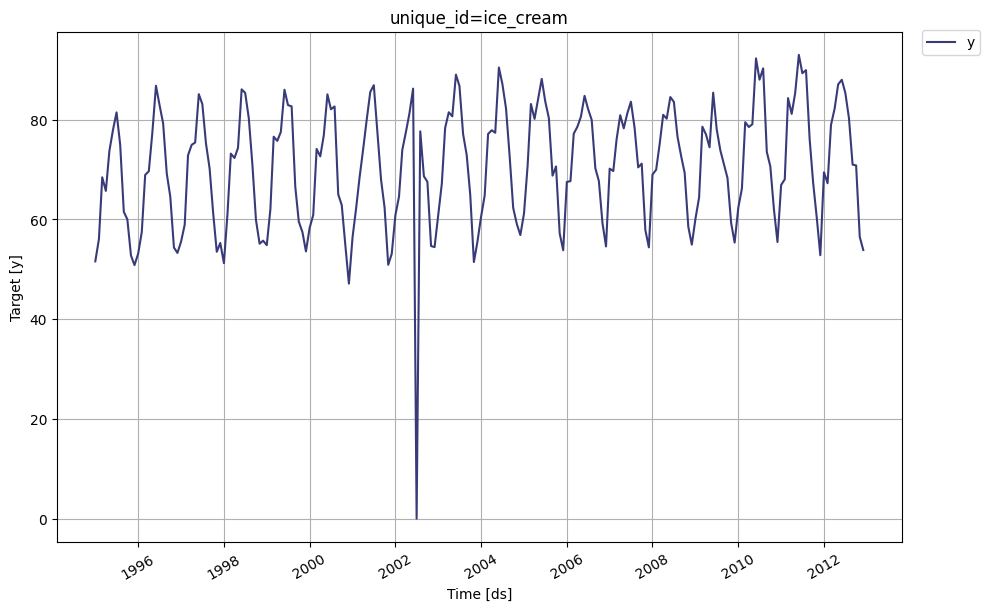

In [16]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


- strong anual seasonal pattern
- 01/07/2002 has 0 sales 

#Fix Anomaly

In [17]:
# mark as missing
df.loc[df["y"] < 5, "y"] = np.nan

# seasonal imputation
df["month"] = df["ds"].dt.month
df["y"] = df["y"].fillna(df.groupby("month")["y"].transform("median"))

df = df.drop(columns="month")

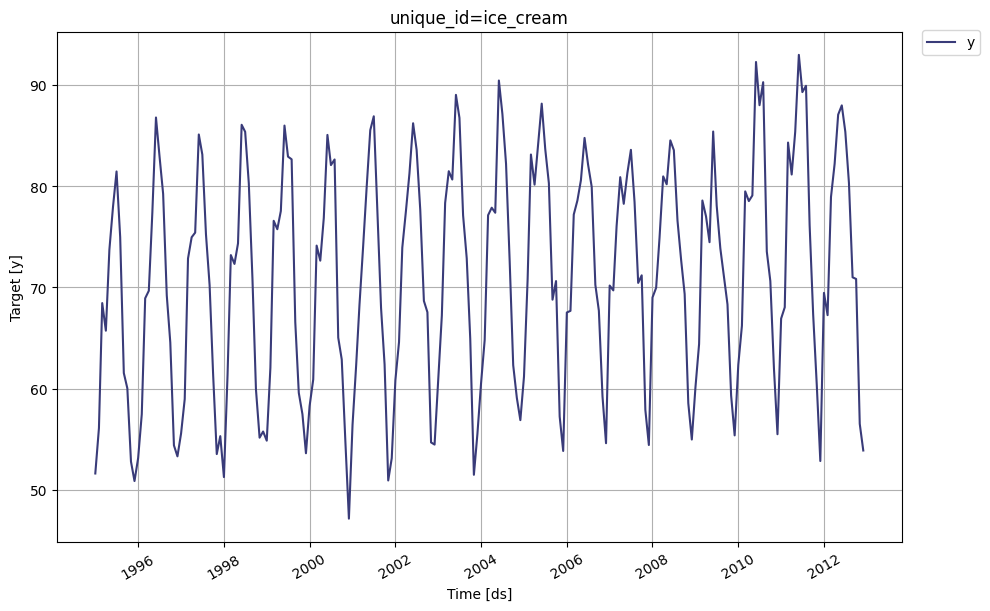

In [18]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


In [19]:
sf = StatsForecast(
    models=[
        SeasonalNaive(season_length=12),

        # SeasonalWindowAverage(season_length=12, window_size=2, alias='SeasWA2'),
        # SeasonalWindowAverage(season_length=12, window_size=3, alias='SeasWA3'),

        AutoARIMA(season_length=12),
        AutoETS(season_length=12),

        ARIMA(order=(1,1,1), seasonal_order=(1,1,1), season_length=12, alias='SARIMA_111_111'),
        ARIMA(order=(2,1,1), seasonal_order=(2,1,1), season_length=12, alias='SARIMA_211_211'),
    ],
    freq="MS",
)


sf.fit(df)
forecast_df = sf.predict(h=12)
forecast_df

,unique_id,ds,SeasonalNaive,AutoARIMA,AutoETS,SARIMA_111_111,SARIMA_211_211
0,ice_cream,2013-01-01,69.463,68.299615,65.940130,66.714421,67.458145
1,ice_cream,2013-02-01,67.259,66.856071,67.168187,67.600297,65.537951
2,ice_cream,2013-03-01,78.959,80.107164,79.441352,79.511077,78.551363
3,ice_cream,2013-04-01,82.236,81.900569,80.135838,80.967039,80.449140
4,ice_cream,2013-05-01,87.093,84.533886,82.132872,83.629228,81.703033
5,ice_cream,2013-06-01,88.012,89.662919,88.217943,88.757347,87.786189
6,ice_cream,2013-07-01,85.400,86.484468,85.036830,85.802562,84.218341
7,ice_cream,2013-08-01,80.328,82.628177,82.245369,82.260225,80.301288
8,ice_cream,2013-09-01,71.003,73.077828,72.009437,72.388085,71.317884
9,ice_cream,2013-10-01,70.840,71.434866,68.789179,69.805020,69.972806


In [20]:
len(forecast_df)

12

### Baselines

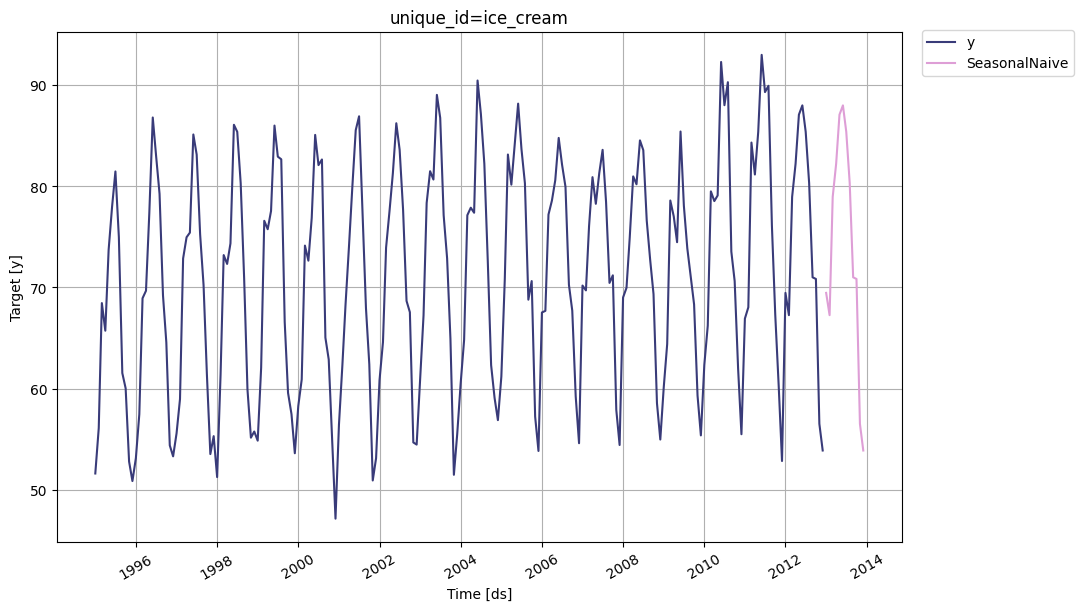

In [21]:
# Seasonal Naive

f = sf.plot(df, forecast_df, models=['SeasonalNaive'])
f.set_figwidth(9)
f.set_figheight(6)
f

### AutoArima and AutoETS

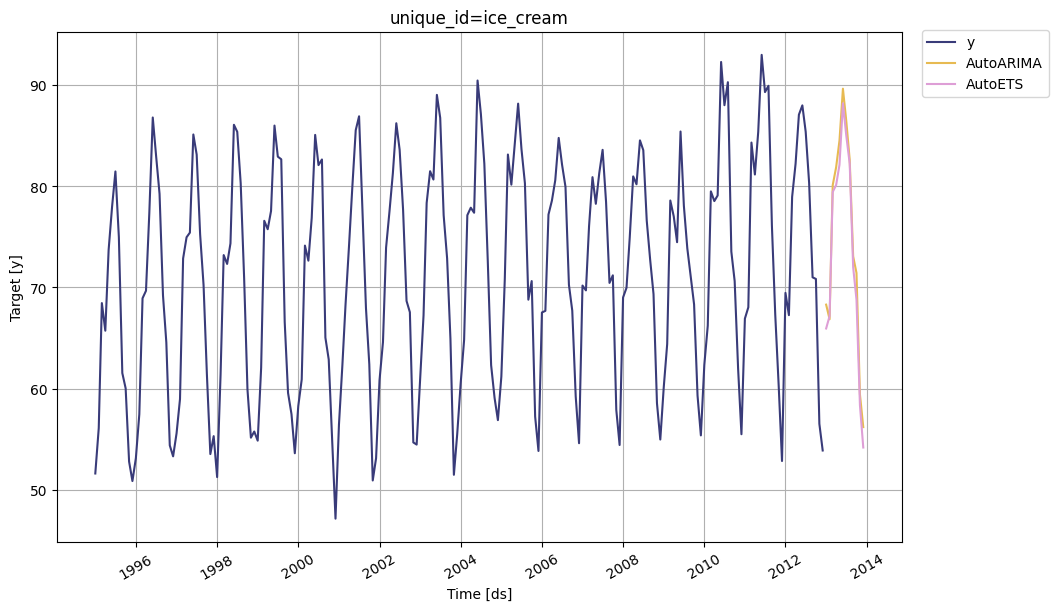

In [22]:
# Seasonal Window Average 2 and 3 seasons

f = sf.plot(df, forecast_df, models=['AutoARIMA', 'AutoETS'])
f.set_figwidth(9)
f.set_figheight(6)
f

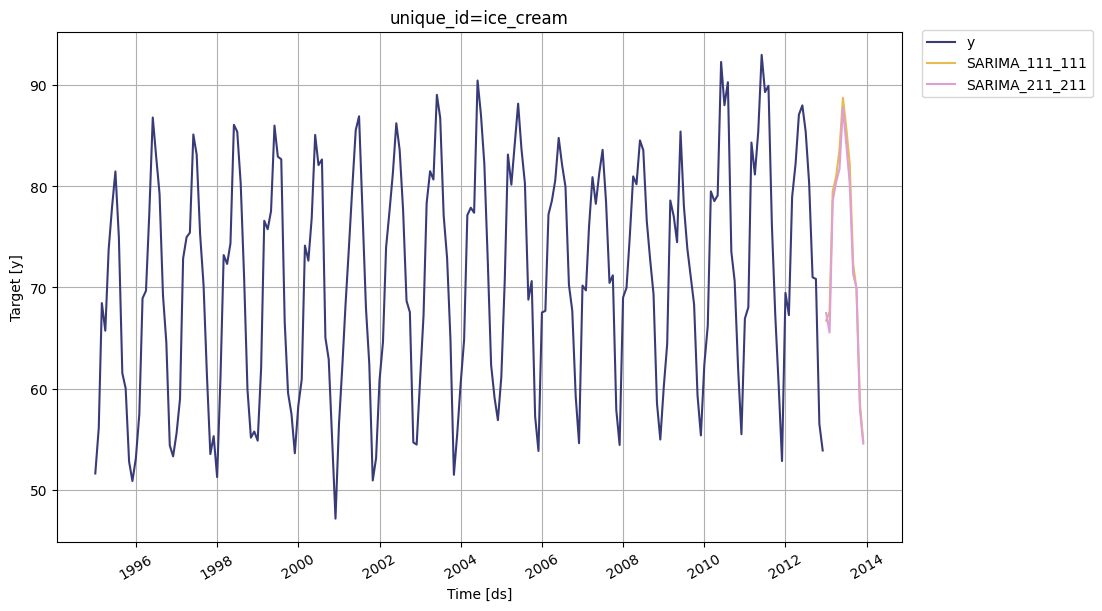

In [23]:
# Seasonal ARIMA

f = sf.plot(df, forecast_df, models=['SARIMA_111_111', 'SARIMA_211_211'])
f.set_figwidth(9)
f.set_figheight(6)
f

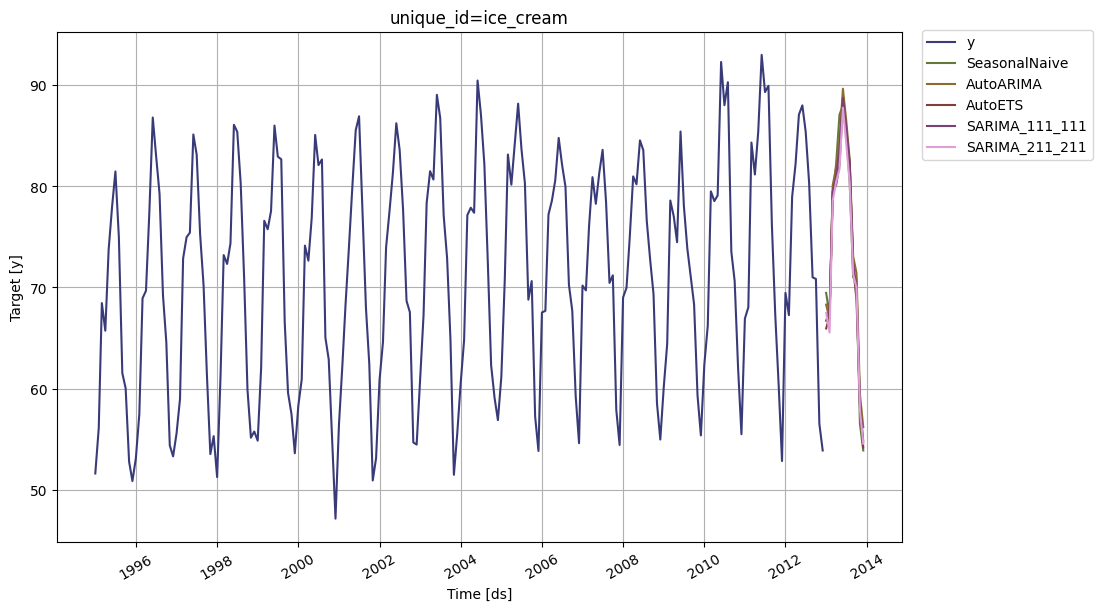

In [24]:
# Seasonal ARIMA

f = sf.plot(df, forecast_df, models=['SeasonalNaive', 'AutoARIMA', 'AutoETS', 'SARIMA_111_111', 'SARIMA_211_211'])
f.set_figwidth(9)
f.set_figheight(6)
f

#Checking Prediction Residuals

In [25]:
res = pd.DataFrame({
    'ds': df.ds,
    'fitted': sf.fitted_[0, 0].model_.get("fitted"),
    'actual': df.y
})

res['residuals'] = res.actual - res.fitted

res.tail()

,ds,fitted,actual,residuals
211,2012-08-01,89.949,80.328,-9.621
212,2012-09-01,76.134,71.003,-5.131
213,2012-10-01,67.334,70.840,3.506
214,2012-11-01,60.303,56.506,-3.797
215,2012-12-01,52.829,53.870,1.041


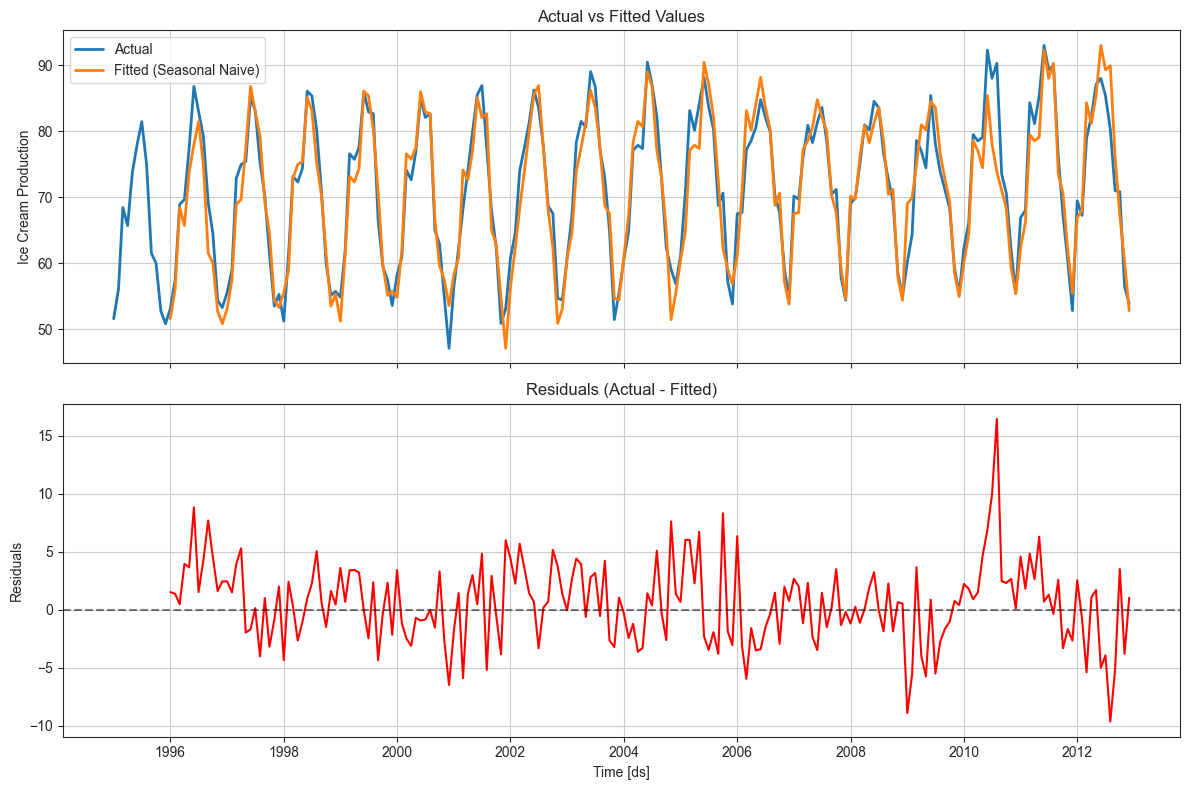

In [26]:
sns.set_style("ticks", {'axes.grid': True})

fig, axs = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

sns.lineplot(x='ds', y='actual', data=res, label='Actual', ax=axs[0], linewidth=2)
sns.lineplot(x='ds', y='fitted', data=res, label='Fitted (Seasonal Naive)', ax=axs[0], linewidth=2)

sns.lineplot(x='ds', y='residuals', data=res, ax=axs[1], color='red', linewidth=1.5)
axs[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

axs[0].set_xlabel('')
axs[0].set_ylabel('Ice Cream Production')
axs[0].set_title('Actual vs Fitted Values')
axs[1].set_xlabel('Time [ds]')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residuals (Actual - Fitted)')

plt.tight_layout()
plt.show()

In [27]:
cv = sf.cross_validation(
    df=df,
    h=12,
    step_size=1,
    n_windows=24
)

In [29]:
scores = evaluate(cv, metrics=[rmse])
scores

,unique_id,cutoff,metric,SeasonalNaive,AutoARIMA,AutoETS,SARIMA_111_111,SARIMA_211_211
0,ice_cream,2010-01-01,rmse,6.348163,6.226293,5.593000,6.052280,5.591355
1,ice_cream,2010-02-01,rmse,6.348353,6.224168,5.425441,6.041460,5.879858
2,ice_cream,2010-03-01,rmse,6.494352,5.931810,5.407565,6.072201,5.281515
3,ice_cream,2010-04-01,rmse,6.524000,5.910799,5.617371,6.104384,5.235299
4,ice_cream,2010-05-01,rmse,6.639248,4.917496,5.775412,6.217150,4.813825
5,ice_cream,2010-06-01,rmse,6.338575,4.380480,4.809166,5.333057,3.941188
6,ice_cream,2010-07-01,rmse,5.663970,3.706336,3.790836,4.636512,4.584971
7,ice_cream,2010-08-01,rmse,3.093722,3.016586,2.665709,3.105440,8.225086
8,ice_cream,2010-09-01,rmse,3.101734,2.576212,2.798642,3.220925,4.058251
9,ice_cream,2010-10-01,rmse,3.175136,2.797152,2.906530,3.261091,3.393256


In [30]:
best_model_name = scores.index[0]
best_model_name

0

In [31]:
model_cols = [
    "SeasonalNaive",
    "AutoARIMA",
    "AutoETS",
    "SARIMA_111_111",
    "SARIMA_211_211",
]

mean_rmse = (
    scores[model_cols]
    .mean()
    .sort_values()
)

mean_rmse


AutoARIMA         3.735752
AutoETS           3.933145
SeasonalNaive     4.237994
SARIMA_111_111    4.267998
SARIMA_211_211    4.348662
dtype: float64

In [32]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

sf_final = StatsForecast(
    models=[AutoETS(season_length=12)],
    freq="MS"
)

sf_final.fit(df)
forecast_2013 = sf_final.predict(h=12)
forecast_2013


,unique_id,ds,AutoETS
0,ice_cream,2013-01-01,65.940130
1,ice_cream,2013-02-01,67.168187
2,ice_cream,2013-03-01,79.441352
3,ice_cream,2013-04-01,80.135838
4,ice_cream,2013-05-01,82.132872
5,ice_cream,2013-06-01,88.217943
6,ice_cream,2013-07-01,85.036830
7,ice_cream,2013-08-01,82.245369
8,ice_cream,2013-09-01,72.009437
9,ice_cream,2013-10-01,68.789179


In [34]:
print(forecast_2013["AutoETS"].values)

[65.94013018 67.16818679 79.44135191 80.13583795 82.13287222 88.21794295
 85.03683015 82.24536857 72.00943667 68.78917877 58.35321325 54.16445898]
